# Denoising Covulational Autoencoder with Gaussian Noise


In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST('../data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST('../data', train=False,
                                  download=True, transform=transform)
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=0)

ModuleNotFoundError: No module named 'torch'

### Visualize the Data

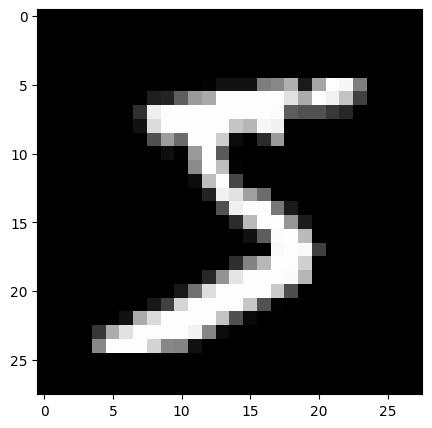

In [2]:
 # obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(32, 16, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(16, 8, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(8, 8, 3, stride=2)  
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(8, 16, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 32, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(32, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x
# initialize the NN
model = ConvDenoiser()


In [4]:
# specify loss function
criterion = nn.MSELoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model.to(device)
summary(model, (1, 28, 28))


Selected device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           4,624
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Conv2d-5              [-1, 8, 7, 7]           1,160
         MaxPool2d-6              [-1, 8, 3, 3]               0
   ConvTranspose2d-7              [-1, 8, 7, 7]             584
   ConvTranspose2d-8           [-1, 16, 14, 14]             528
   ConvTranspose2d-9           [-1, 32, 28, 28]           2,080
           Conv2d-10            [-1, 1, 28, 28]             289
Total params: 9,585
Trainable params: 9,585
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.50
Params size (MB)

Epoch: 1 	Training Loss: 0.755927
Epoch: 2 	Training Loss: 0.496784
Epoch: 3 	Training Loss: 0.453713
Epoch: 4 	Training Loss: 0.428308
Epoch: 5 	Training Loss: 0.406098
Epoch: 6 	Training Loss: 0.387081
Epoch: 7 	Training Loss: 0.372111
Epoch: 8 	Training Loss: 0.359368
Epoch: 9 	Training Loss: 0.349016
Epoch: 10 	Training Loss: 0.340200
Epoch: 11 	Training Loss: 0.332601
Epoch: 12 	Training Loss: 0.325851
Epoch: 13 	Training Loss: 0.320076
Epoch: 14 	Training Loss: 0.315790
Epoch: 15 	Training Loss: 0.311350
Epoch: 16 	Training Loss: 0.307418
Epoch: 17 	Training Loss: 0.303958
Epoch: 18 	Training Loss: 0.300724
Epoch: 19 	Training Loss: 0.298123
Epoch: 20 	Training Loss: 0.295325


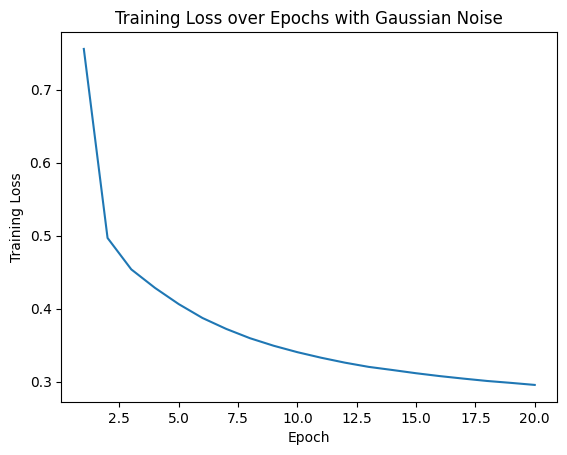

In [5]:
# number of epochs to train the model
n_epochs = 20
train_losses = []
# for adding noise to images
noise_factor=0.3

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        images = images.to(device)
        
        #Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1 (also called the standard normal distribution).
        noisy_imgs = images + noise_factor * torch.randn(*images.shape).to(device)
        # Clip the images to be between 0 and 1
        noisy_imgs = torch.clamp(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))
plt.plot(range(1, n_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs with Gaussian Noise')
plt.show()

## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

Average SSIM: 0.820929


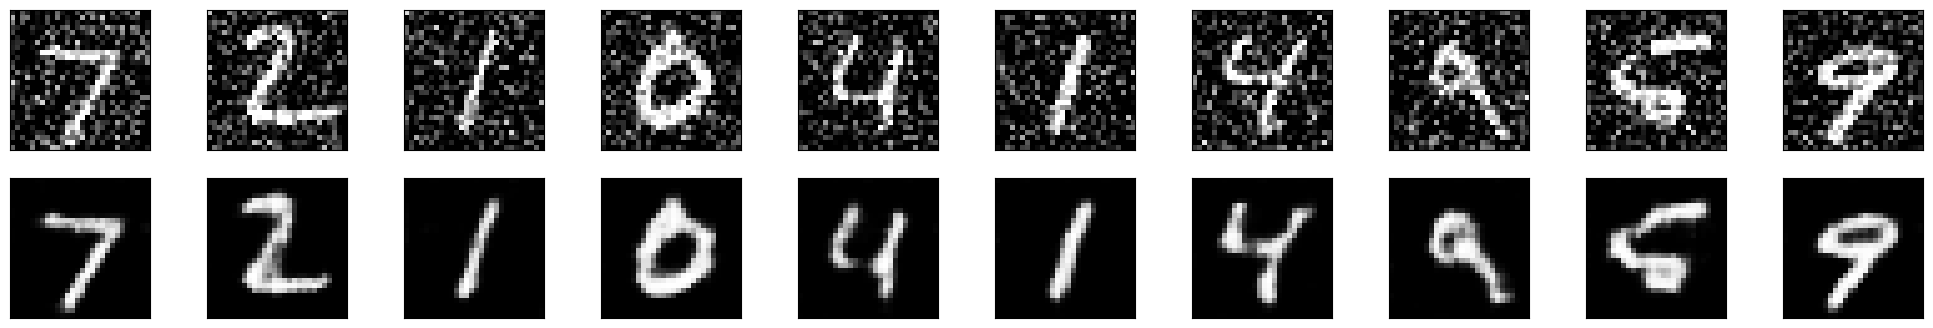

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
model.to("cpu")
# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

output = model(noisy_imgs)
#get ssim and psnr values
ssim_values = []

#calculating errors of all images
for i in range(images.size(0)):
    original_img = images[i].unsqueeze(0)
    denoised_img = output[i].unsqueeze(0)

    ssim_val = ssim(original_img, denoised_img, data_range=1.0).item()
    ssim_values.append(ssim_val)

avg_ssim = np.mean(ssim_values)

print(f"Average SSIM: {avg_ssim:.6f}")
# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)